In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from scipy.optimize import fmin_bfgs
from scipy.optimize import fmin

%config InlineBackend.figure_format = 'retina'
#%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0,6.0)
print("Setup Complete")

Setup Complete


# Logisitic Regression

In [2]:
f = open("AndrewNg/ex2data1.txt")
df = pd.read_csv(f,names=["Score_Ex1","Score_Ex2","isAdmitted"])
df.describe()

,Score_Ex1,Score_Ex2,isAdmitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


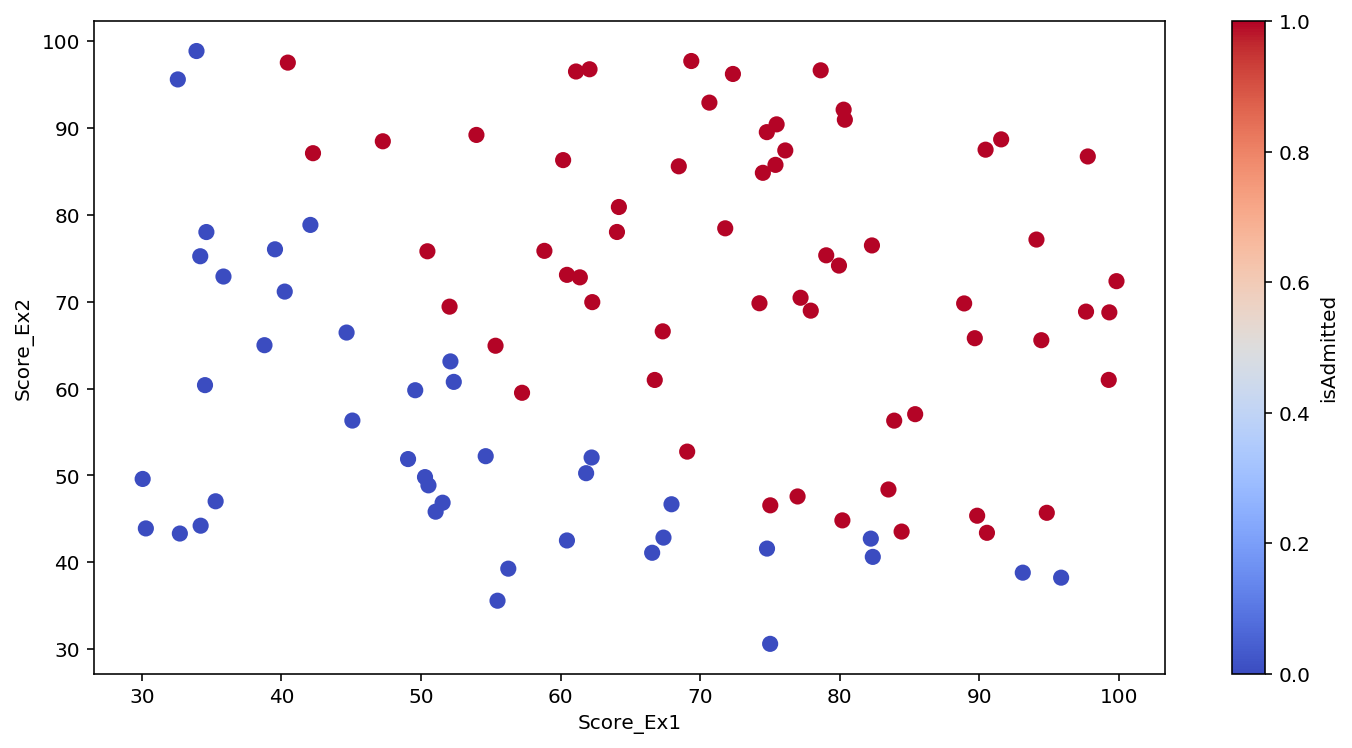

In [3]:
fg, ax_scatter = plt.subplots()
df.plot(x="Score_Ex1",y="Score_Ex2",c="isAdmitted",kind='scatter',colormap="coolwarm",s=50,ax=ax_scatter)
plt.show()

In [4]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [5]:
def CstFun(theta,m,x,y):
    h = sigmoid(np.dot(np.transpose(theta),x)) # Following the formula here
    J = 1/m*(-np.dot(np.log(h),np.transpose(y))-np.dot(np.log(1-h),np.transpose(1-y))) #MOVED y TO 2ND!!
    return J.item() #return the value only
def Norm(x):
    mean = np.mean(x,axis=0)
    std = np.std(x,axis=0)
    return (x-mean)/std

In [6]:
theta = np.zeros((3,1))
m = len(df.iloc[:,0])
X = np.ones((1,m))

for i in range(len(df.iloc[0])-1):
    a = Norm(df.iloc[:,i].values) #Feature normalization. Do not normalize 1!
    a = a.reshape(1,-1)
    X = np.append(X,a,axis=0)
#print(X)
Y = df["isAdmitted"].values.reshape(1,m)
CstFun(theta,m,X,Y)

0.6931471805599452

In [7]:
guess = np.array([0.1,1,1])
minT = fmin_bfgs(CstFun,guess,args=(m,X,Y))
print(minT)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 19
         Function evaluations: 100
         Gradient evaluations: 20
[1.71844717 3.99286235 3.72515041]


In [8]:
print("J value from " + str(CstFun(theta,m,X,Y)) + " to " + str(CstFun(minT,m,X,Y)))

J value from 0.6931471805599452 to 0.203497701694116


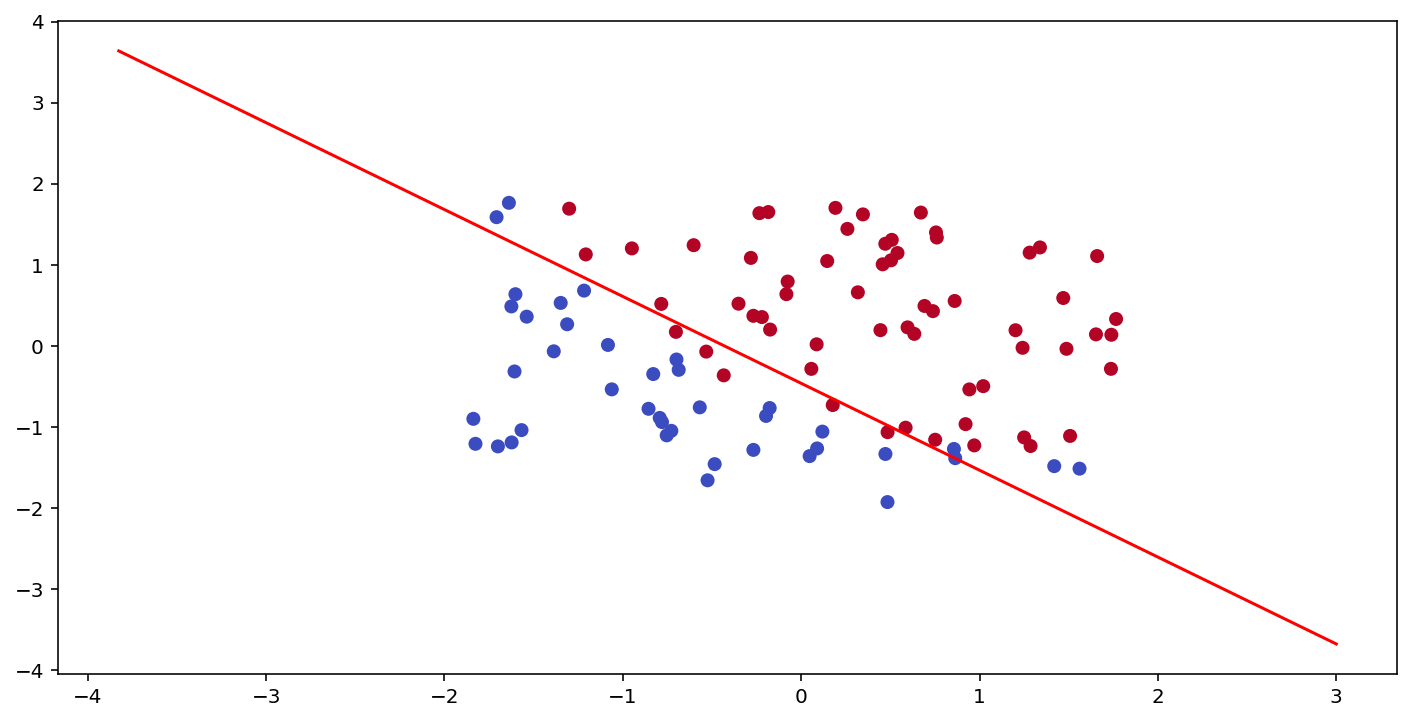

In [9]:
fg,ax = plt.subplots()

#Some decision boundary formula...
## Only need 2 points to define a line, so choose two endpoints
x1 = np.array([min(X[:,1])-2,max(X[:,1])+2])
## Calculate the decision boundary line
x2 = -(minT[0]+minT[1]*x1)/minT[2]
line = plt.plot(x1,x2,"r",label="Decision Boundary")

Score1_norm = Norm(df["Score_Ex1"].values)
Score2_norm = Norm(df["Score_Ex2"].values)

plt.scatter(x=Score1_norm,y=Score2_norm,c=df["isAdmitted"].values,cmap="coolwarm")

plt.show()

In [10]:
data1 = np.array([1,(45-df["Score_Ex1"].mean())/df["Score_Ex1"].std(),(85-df["Score_Ex2"].mean())/df["Score_Ex2"].std()])
perdict = sigmoid(minT.dot(data1))
print(perdict)

0.7766915538777618


In [11]:
def classPerdict(theta,x):
    pred = np.dot(theta,x)
    return pred>0

def Performance(pred,y):
    percent = np.sum(pred==y)/y.size
    return str(percent*100)+"% Accuracy"

Performance(classPerdict(minT,X),Y)

'89.0% Accuracy'

# Now with regularization

In [12]:
f2 = open('AndrewNg/ex2data2.txt')
df2 = pd.read_csv(f2,names=["Test1","Test2","isPassed"])
df2.head()

,Test1,Test2,isPassed
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [13]:
df2.describe()

,Test1,Test2,isPassed
count,118.000000,118.000000,118.000000
mean,0.054779,0.183102,0.491525
std,0.496654,0.519743,0.502060
min,-0.830070,-0.769740,0.000000
25%,-0.372120,-0.254385,0.000000
50%,-0.006336,0.213455,0.000000
75%,0.478970,0.646562,1.000000
max,1.070900,1.108900,1.000000


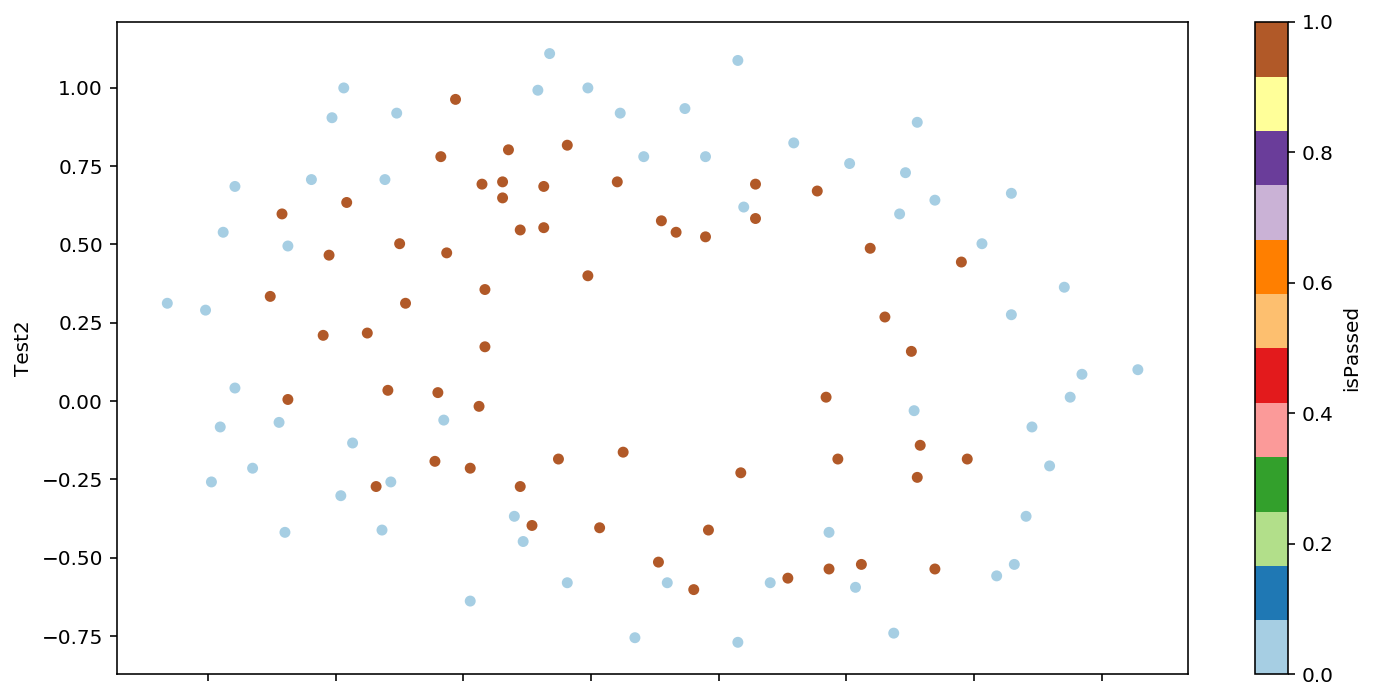

In [14]:
df2.plot.scatter(x="Test1",y="Test2",c="isPassed",colormap='Paired')

In [20]:
def mapFeature(x1,x2,power):
    xout = np.ones((1,x1.size)) #Use size for # of columns!
    count = 0
    for i in range(1,power+1):
        for j in range(0,i+1):
            curterm = (x1**j)*(x2**(i-j)).reshape(1,-1) #use te operator * -> elementwise operation.
            xout = np.vstack((xout,curterm))
            count+=1
    #print(curterm.shape)
    #print(count)
    #print(xout.shape)
    return xout

In [16]:
X1 = df2["Test1"].values.reshape(1,-1) #-1 is left for numpy to figure out
X2 = df2["Test2"].values.reshape(1,-1)
Xin = mapFeature(X1,X2,6)
Yin = df2["isPassed"].values.reshape(1,-1)
Yin.shape


(28, 118)


(1, 118)

In [17]:
def RegCstFun(theta,m,x,y,lamb):
    h = sigmoid(np.dot(np.transpose(theta),x)) # Following the formula here
    J = 1/m*(-np.dot(np.log(h),np.transpose(y))-np.dot(np.log(1-h),np.transpose(1-y))) + lamb/2/m*np.sum(theta**2) #MOVED y TO 2ND!!
    return J.item() #return the value only

In [18]:
theta2 = np.zeros((28,1))
print(RegCstFun(theta2,X1.size,Xin,Yin,1))

0.6931471805599453


In [84]:
mod_theta = fmin_bfgs(RegCstFun,theta2,args=(X1.size,Xin,Yin,1))
print(mod_theta)

Optimization terminated successfully.
         Current function value: 0.535160
         Iterations: 46
         Function evaluations: 1410
         Gradient evaluations: 47
[ 1.14216776  1.16719568  0.60159657 -1.27009735 -0.91585553 -1.87133814
 -0.17359509 -0.34493668 -0.36845878  0.12635755 -1.16298475 -0.26932553
 -0.60654115 -0.04896946 -1.42386107 -0.46905341 -0.2867602  -0.28027302
 -0.04338818 -0.2068904  -0.24354158 -0.93193312 -0.13798757 -0.32900577
  0.01716413 -0.29266098  0.02900135 -1.0365073 ]


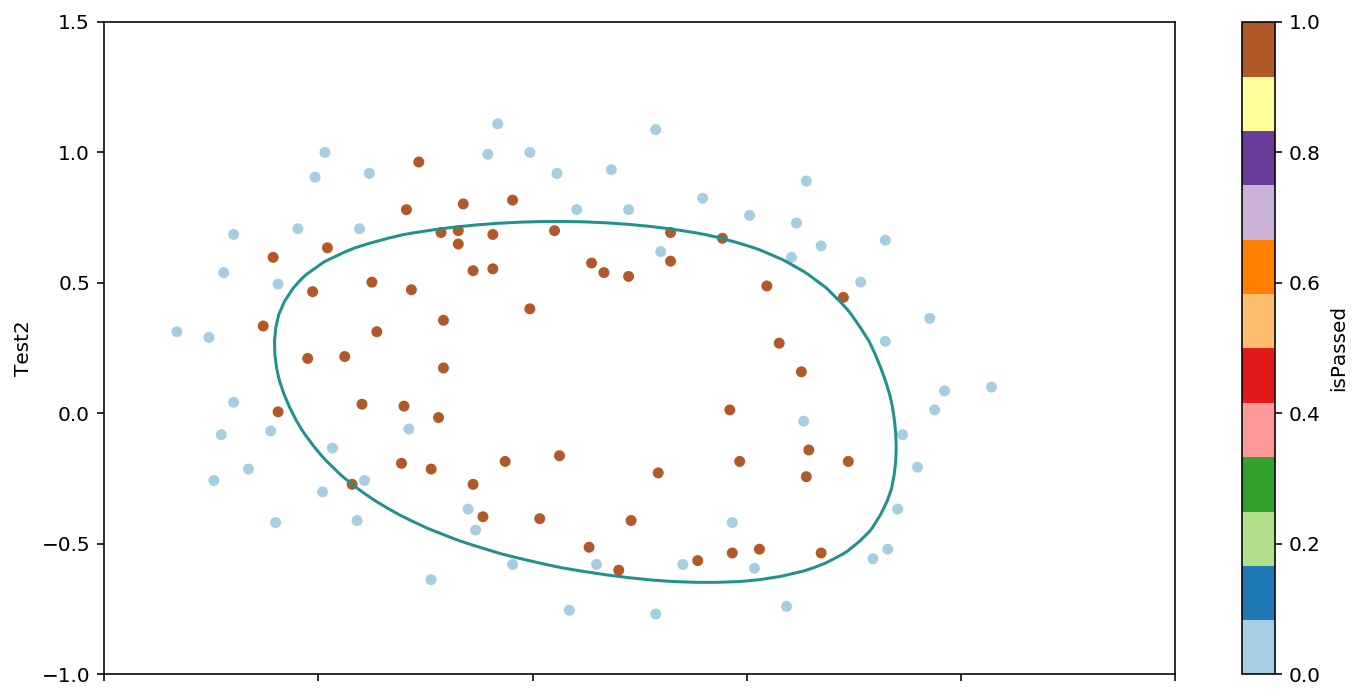

[[ -8.58698693  -7.95848646  -7.41463126 ... -18.89649768 -21.86556982
  -25.30120952]
 [ -7.78773218  -7.16951669  -6.63489269 ... -17.87280538 -20.81867109
  -24.23018008]
 [ -7.09759416  -6.48894381  -5.96290997 ... -16.99963474 -19.92581962
  -23.3169306 ]
 ...
 [-19.8010434  -19.10468498 -18.50628916 ... -47.99041825 -52.66674306
  -57.95945401]
 [-23.04390492 -22.32608388 -21.70845787 ... -52.41143963 -57.2000283
  -62.61284266]
 [-26.79487151 -26.05371152 -25.41513284 ... -57.40044115 -62.30663649
  -67.84515517]]


In [85]:
#Plot Decision Boundary for higher dimension polys
def plotDB(theta,x,y,power):
    u = np.linspace(-1,1.5,50)
    v = np.linspace(-1,1.5,50)
    z = np.zeros((len(u),len(v)))
    for i in range(0,len(u)):
        for j in range(0,len(v)):
            z[i][j]=np.dot(theta,mapFeature(u[i],v[j],power))
    return plt.contour(u,v,z,0),z

df2.plot.scatter(x="Test1",y="Test2",c="isPassed",colormap='Paired')
ax,z = plotDB(mod_theta.reshape(1,-1),Xin,Yin,6)
plt.show()
print(z)

In [79]:
Performance(classPerdict(mod_theta,Xin),Yin)

'88.98305084745762% Accuracy'

# Varying lambda for a looser or tighter DB!